In [1]:
!pip install mne


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
!pip install mne-bids


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np  #to handle data arrays, etc
import pandas as pd  #handles tsv files, etc
import matplotlib.pyplot as plt #for plotting and visualisations
import mne  #actual library to deal with vhrd extensions and the like, actual neuro stuff
import mne_bids  #for ease of finding subject data using standard BIDS format and not having to type path every time
from utils import resample, smooth_signal
"""
from scipy.signal import resample_poly  #library to build our resample function from scratch
from fractions import Fraction
def resample(x, sr1, sr2, axis = 0): 
    a, b = Fraction(sr1, sr2)._numerator, Fraction(sr1, sr2)._denominator  #extracting num and denom to pass as arguments in the resample_poly function
    return resample_poly(x, a, b, axis).astype(np.float32)  #it upsamples, does a low pass filterig (to prevent alisaing) ad downsamples too
def smooth_signal(y, n): #to smooth out the sudden spikes in the data by taking help of neighbouring points fitted into a 'box'
    box = np.ones(n)/n
    ys = np.convolve(y, box, mode = 'same')    
    return ys
"""

"\nfrom scipy.signal import resample_poly  #library to build our resample function from scratch\nfrom fractions import Fraction\ndef resample(x, sr1, sr2, axis = 0): \n    a, b = Fraction(sr1, sr2)._numerator, Fraction(sr1, sr2)._denominator  #extracting num and denom to pass as arguments in the resample_poly function\n    return resample_poly(x, a, b, axis).astype(np.float32)  #it upsamples, does a low pass filterig (to prevent alisaing) ad downsamples too\ndef smooth_signal(y, n): #to smooth out the sudden spikes in the data by taking help of neighbouring points fitted into a 'box'\n    box = np.ones(n)/n\n    ys = np.convolve(y, box, mode = 'same')    \n    return ys\n"

In [4]:
bids_dir = '../../../'  #sets the root folder where the dataset is, and it is a relative path
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')  #looks for the participants.tsv file by scanning bids_dir, returning list of all sunject ids found
subject = '01' #I want sub-01
acquisition = 'clinical' #I want the clinical setup of electrodes
task = 'rest' #I want the movie task, not rest task
run = '4'
datatype = 'ieeg'
session = 'iemu'

In [5]:
channels_path = mne_bids.BIDSPath(subject=subject,   #Find me the file for subject 01, session iemu, task film, which ends in _channels.tsv, which can be done through python string formatting too
                                    session=session, #but this just seems like a way more elegant method than that, and is not a literal nightmare to read when I view my code again, unlike python string formatting
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)  #first off it tells pandas that the columns in the file are tab separated (not comma as usual), and also the match[0] basically just 
                                                                                           #takes the first file in the list of matching files it finds
                                                                                           #after this line, what you get is a variable called 'channels' which is a neat little table of info about all electrodes (name, type, good/bad, etc)

In [6]:
data_path = mne_bids.BIDSPath(subject=subject,       #yet another search query like earlier, but this actually looks for the data file with vhdr extension
                                    session=session, 
                                    suffix='ieeg',
                                    extension='vhdr', #vhdr is like a header file, which truly tells the computer how to read the eeg file which has binary data
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)  #brain data loaded into 'raw', one tiny thing - preload set to False tells the computer not to load the actual large data into the RAM yet, just read the info (not so tiny after all)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})  #something rather funny would happen here if you didn't run this, because your computer shouldn't process heart rate, etc as braiwaves, so you label everything irrevelant to our neuroanalysis as 'misc'
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])  #and of course, why keep those irrelevant files, delete those!

Extracting parameters from ../../../sub-01/ses-iemu/ieeg/sub-01_ses-iemu_task-rest_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


C:\Users\USER\AppData\Local\Temp\ipykernel_28052\1895643318.py:10: RuntimeWarning: The unit for channel(s) AH+, ECG+, EMG+, MKR1+, MKR2+, ORB+, abdo+, thor+ has changed from V to NA.
  raw.set_channel_types({ch_name: str(x).lower()


<RawBrainVision | sub-01_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 103 x 402993 (196.8 s), ~87 KiB, data not loaded>

In [7]:
#list(zip(raw.ch_names, raw.get_channel_types()))


In [8]:
#raw.get_data()[0][:20]


In [9]:
#Visualation 1: Plotting the raw signals to see what the scenario is like before preprocessing
def plot_raw_signals(raw, duration=10, zoom_duration=1):
    """
    Plots raw intracranial EEG signals:
    1. A long window (default 10 s)
    2. A zoomed-in window (default 1 s)
    3. PSD of the raw data (before preprocessing)
    """

    picks = mne.pick_types(raw.info, ecog=True, seeg=True) # pick 3 random channels (that are not misc), i.e. pick out ieeg channels
    np.random.seed(42)  #set a seed so we pick fixed random ones
    selected = np.random.choice(picks, size=3, replace=False) #pick 3 distinct random ieeg channels

    ch_names = [raw.ch_names[i] for i in selected] #just fixing a variable for the array we got

    # Extract data for the selected channels
    sfreq = raw.info['sfreq']  #from mne metadata
    start = 0 #we start from the first sample
    stop = int(start + duration * sfreq) #start + how many samples in the duration we desire to look at

    # 1) Extract data (samples) for the chosen channels and time window (same as before)
    long_data = raw.get_data(picks=selected)[:, start:stop]  # -> values in Volts
    
    # 2) Convert Volts -> microvolts (µV) for plotting readability
    long_data_uv = long_data * 1e6   # now units are µV (typical values ~ 5 - 100 µV)
    
    # 3) Quick diagnostics (prints) to help choose offsets if unsure
    print(f"long_data_uv shape: {long_data_uv.shape}")
    print("per-channel min, max, std (µV):")
    for i, ch in enumerate(selected):
        print(f" {ch_names[i]}: min={long_data_uv[i].min():.2f}, max={long_data_uv[i].max():.2f}, std={long_data_uv[i].std():.2f}")
    
    # 4) PLOT: Long window (10 s) with offsets in µV
    time_long = np.linspace(0, duration, long_data_uv.shape[1])
    plt.figure(figsize=(14, 6))
    offset_long = 500  # µV offset between channels (adjust if your signals are much larger/smaller)
    for i in range(long_data_uv.shape[0]):
        plt.plot(time_long, long_data_uv[i] + i * offset_long, label=ch_names[i])
    plt.title(f"Raw iEEG ({duration} seconds)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV) + offset")
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()
    
    # 5) ZOOMED: 1-second window (convert & plot)
    zoom_stop = int(zoom_duration * sfreq)
    zoom_data_uv = long_data_uv[:, :zoom_stop]
    time_zoom = np.linspace(0, zoom_duration, zoom_data_uv.shape[1])
    
    plt.figure(figsize=(14, 5))
    offset_zoom = 300  # smaller offset for zoom view (µV)
    for i in range(zoom_data_uv.shape[0]):
        plt.plot(time_zoom, zoom_data_uv[i] + i * offset_zoom, label=ch_names[i])
    plt.title(f"Raw iEEG (Zoomed-in {zoom_duration} seconds)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV) + offset")
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()


long_data_uv shape: (3, 20480)
per-channel min, max, std (µV):
 ITR4: min=-305.57, max=445.80, std=134.03
 MFL1: min=-370.80, max=575.20, std=124.79
 FOR11: min=-126.95, max=210.84, std=46.56


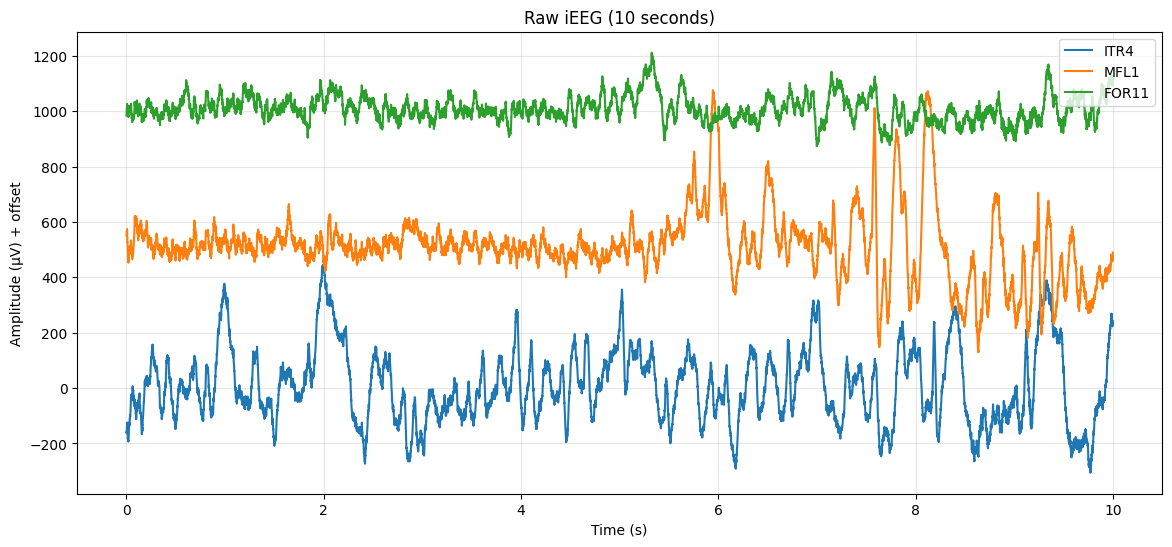

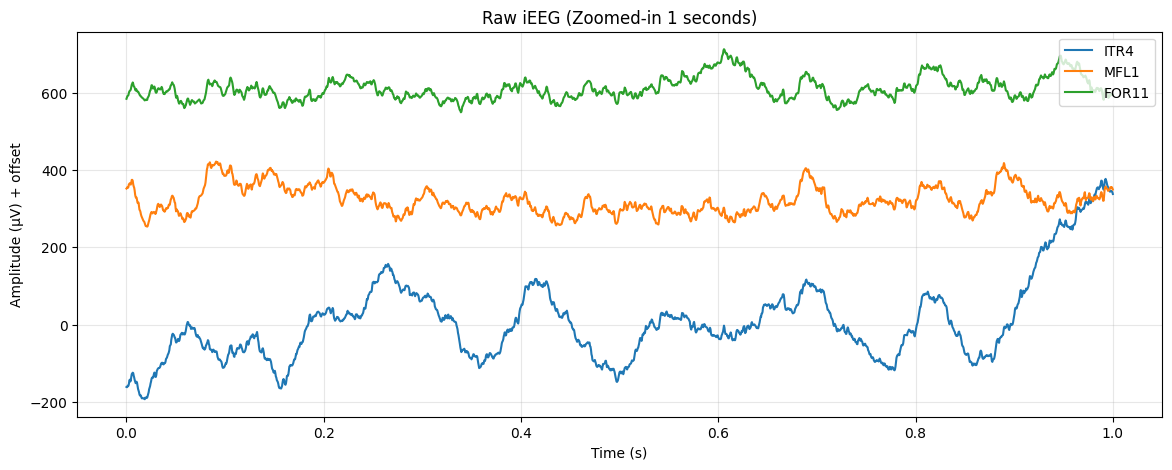

In [10]:
plot_raw_signals(raw)

Bad channels selected: ['MFL15']
Good channels selected: ['AR1']


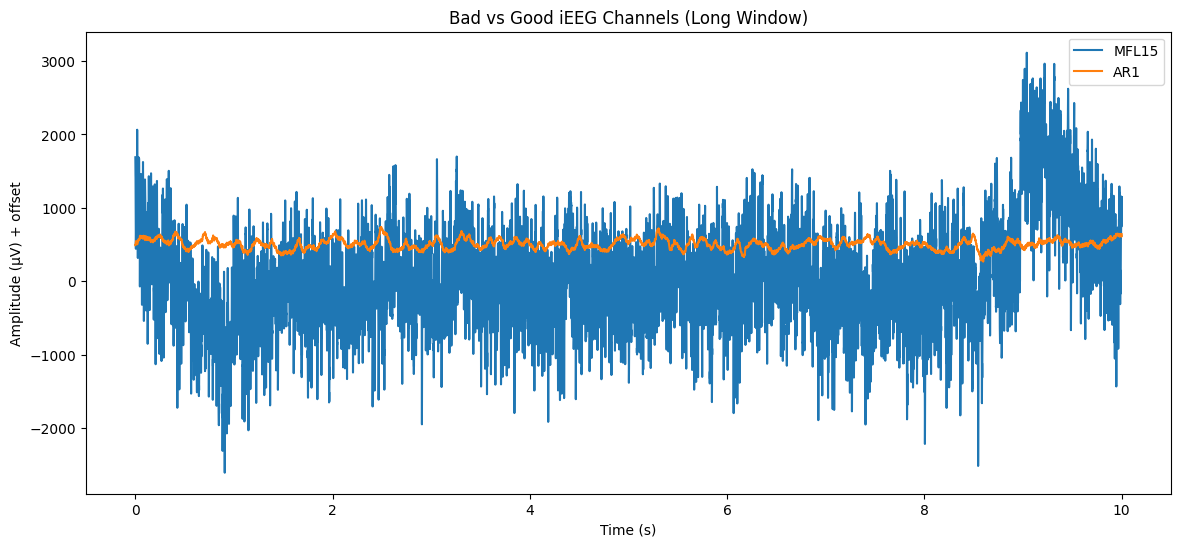

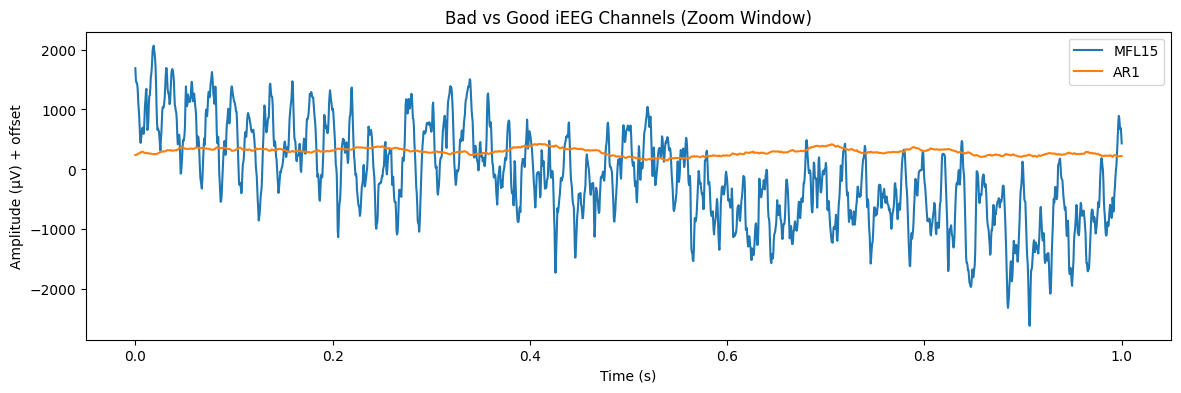

In [11]:
def plot_bad_vs_good(raw, channels, duration=10, zoom_duration=1):
    # Get bad channels from channels.tsv
    bad = channels.loc[channels['status'] == 'bad', 'name'].tolist()
    bad = [ch for ch in bad if ch in raw.ch_names]  # keep only those present in raw
    
    if len(bad) == 0:
        print("No bad channels listed in metadata.")
        return
    
    # Pick 1–3 bad channels to inspect
    bad = bad[:3]
    
    # Pick same number of good channels
    good_all = [ch for ch in raw.ch_names if ch not in bad]
    good = good_all[:len(bad)]
    
    print("Bad channels selected:", bad)
    print("Good channels selected:", good)
    
    # Combine them for plotting
    selected = bad + good
    picks = [raw.ch_names.index(ch) for ch in selected]
    
    sfreq = raw.info['sfreq']
    start = 0
    stop = int(duration * sfreq)
    
    data = raw.get_data(picks=picks)[:, start:stop] * 1e6  # convert to µV
    time_long = np.linspace(0, duration, data.shape[1])
    
    # 10-second plot
    plt.figure(figsize=(14, 6))
    offset = 500
    for i, ch in enumerate(selected):
        plt.plot(time_long, data[i] + i*offset, label=ch)
    plt.title("Bad vs Good iEEG Channels (Long Window)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV) + offset")
    plt.legend()
    plt.show()
    
    # Zoom window
    zoom_samples = int(zoom_duration * sfreq)
    zoom_data = data[:, :zoom_samples]
    time_zoom = np.linspace(0, zoom_duration, zoom_samples)
    
    plt.figure(figsize=(14, 4))
    for i, ch in enumerate(selected):
        plt.plot(time_zoom, zoom_data[i] + i*offset/2, label=ch)
    plt.title("Bad vs Good iEEG Channels (Zoom Window)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV) + offset")
    plt.legend()
    plt.show()

plot_bad_vs_good(raw, channels)


In [12]:
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()  #makes a list of the channel names of bad channels by selecting brain channels that have 'bad' in the channel type column
raw.info['bads'].extend([ch for ch in bad_channels]) #adds the created list to the MNE internal bad list so it ignores them during plotting and stuff
raw.drop_channels(raw.info['bads']) #so these channels are now deleted from memory, they won't mess up our analysis in the future

<RawBrainVision | sub-01_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 102 x 402993 (196.8 s), ~86 KiB, data not loaded>

Sampling rate BEFORE resampling: 2048.0
long_data_uv shape: (3, 20480)
per-channel min, max, std (µV):
 ITR4: min=-305.57, max=445.80, std=134.03
 MFL1: min=-370.80, max=575.20, std=124.79
 FOR11: min=-126.95, max=210.84, std=46.56


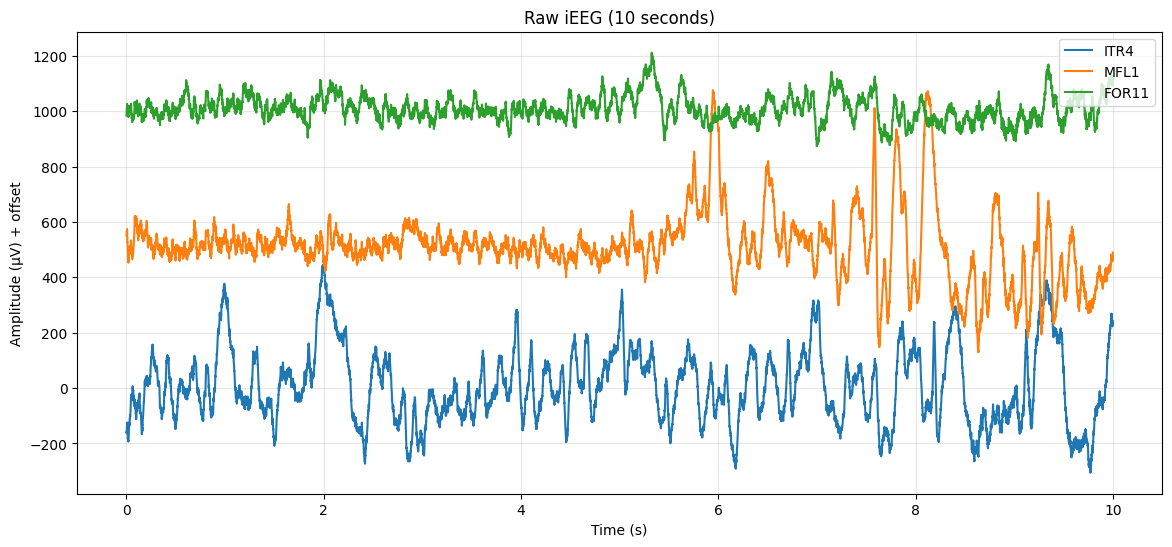

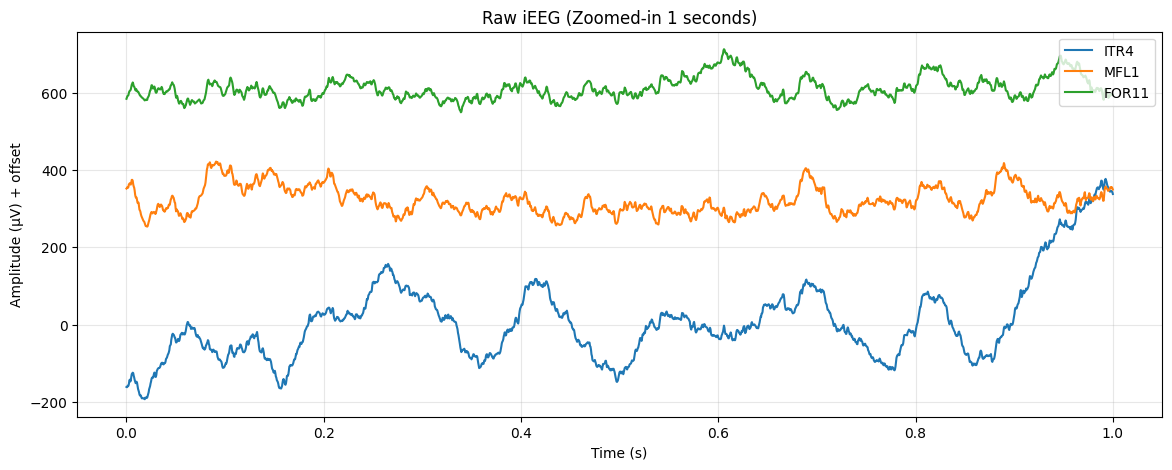

In [13]:
print("Sampling rate BEFORE resampling:", raw.info['sfreq'])

# Plot the raw iEEG signals BEFORE any resampling
plot_raw_signals(raw)


In [14]:
raw.load_data() #until now 'raw' was just a pointer to the file, but to start analysis, it needs to be physically loaded into memory, and so you do just that

Reading 0 ... 402992  =      0.000 ...   196.773 secs...


<RawBrainVision | sub-01_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 102 x 402993 (196.8 s), ~313.7 MiB, data loaded>

In [15]:
#Resampling raw data to 512 Hz to match other subjects
target_fs = 512

# Checking if resampling is needed
if raw.info['sfreq'] != target_fs:
    print(f"Resampling data from {raw.info['sfreq']} Hz to {target_fs} Hz...")
    raw.resample(sfreq=target_fs)   #its a good function to resample and is easier than the custom function
    print("Resampling complete!")  #success! resampling done
else:
    print(f"Data is already at {target_fs} Hz.")  #lucky, you don't need to resample

Resampling data from 2048.0 Hz to 512 Hz...
Resampling complete!


Sampling rate AFTER resampling: 512.0
long_data_uv shape: (3, 5120)
per-channel min, max, std (µV):
 ITR4: min=-301.38, max=446.64, std=134.00
 MFL1: min=-367.35, max=573.00, std=124.77
 FOR11: min=-126.30, max=209.92, std=46.50


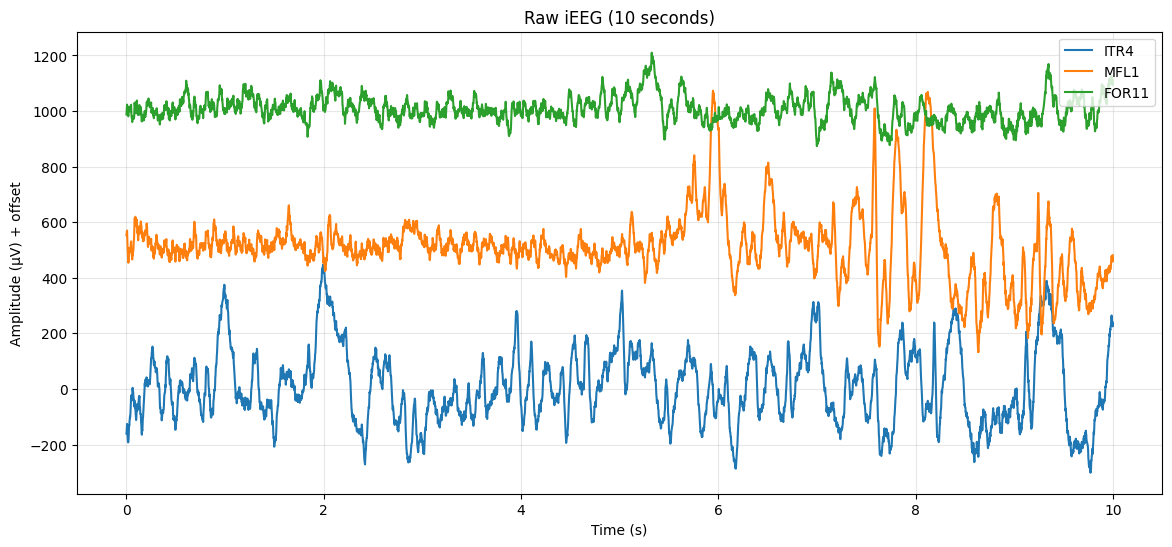

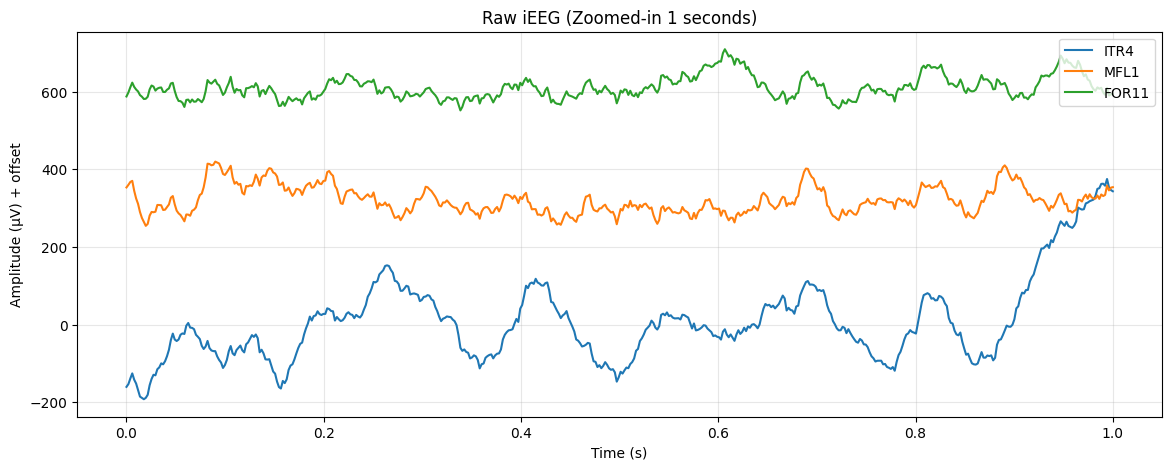

In [16]:
print("Sampling rate AFTER resampling:", raw.info['sfreq'])

# Plot the raw signals AFTER resampling to 512 Hz
plot_raw_signals(raw)


Computing PSD to check for line noise...
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


C:\Users\USER\AppData\Local\Temp\ipykernel_28052\3881812660.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig_full = spectrum.plot(show=False)


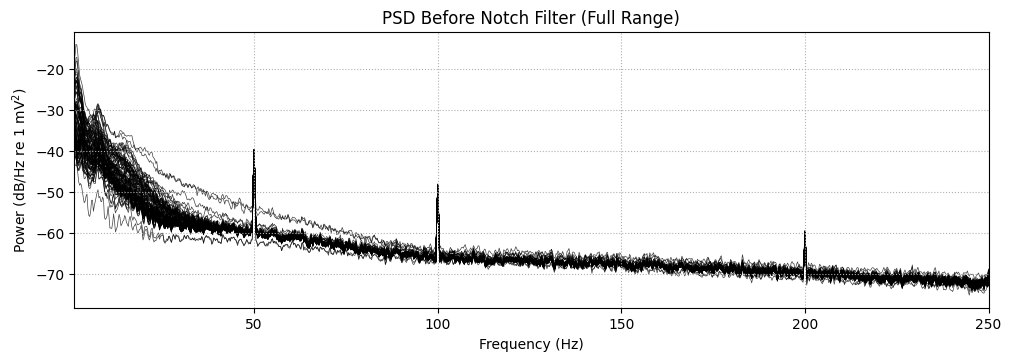

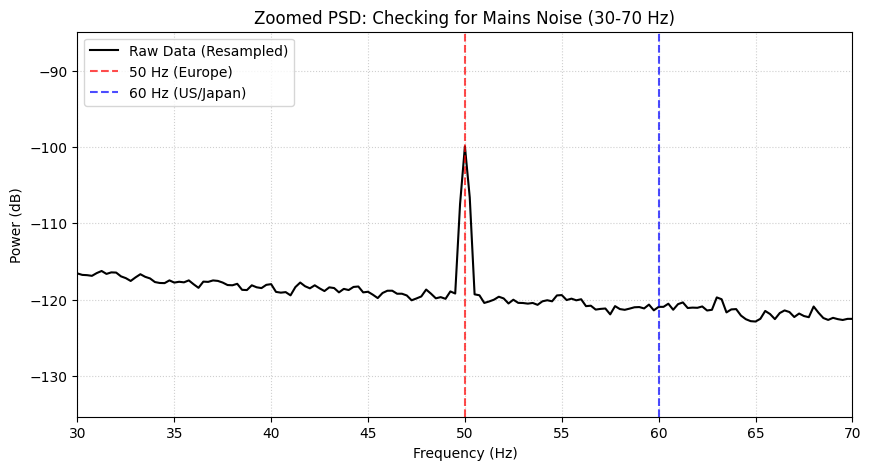

In [17]:
# --- INSERT THIS CODE BLOCK AFTER RESAMPLING & BEFORE NOTCH FILTER ---

import matplotlib.pyplot as plt
import numpy as np

print("Computing PSD to check for line noise...")

# 1. Compute the Power Spectral Density (PSD)
# We calculate up to 250Hz since your sampling rate is 512Hz
spectrum = raw.compute_psd(method='welch', fmin=1, fmax=250, n_fft=2048, n_overlap=1024)

# 2. Plot 1: Full Frequency Range (0-250 Hz)
# Good for checking the general "shape" of the data (1/f slope)
fig_full = spectrum.plot(show=False)
plt.title("PSD Before Notch Filter (Full Range)")
plt.show()

# 3. Plot 2: Zoomed-in Check (30Hz - 70Hz)
# This will show you the activity around the mains frequency
psds, freqs = spectrum.get_data(return_freqs=True)
avg_psd_db = 10 * np.log10(psds.mean(axis=0)) # Average across all channels

plt.figure(figsize=(10, 5))
plt.plot(freqs, avg_psd_db, color='black', linewidth=1.5, label='Raw Data (Resampled)')

# Add vertical lines for reference
plt.axvline(50, color='red', linestyle='--', alpha=0.7, label='50 Hz (Europe)')
plt.axvline(60, color='blue', linestyle='--', alpha=0.7, label='60 Hz (US/Japan)')

# --- UPDATED RANGE HERE (30 to 70 Hz) ---
plt.xlim(30, 70)  
plt.title("Zoomed PSD: Checking for Mains Noise (30-70 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.legend()
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.show()

In [18]:
raw.notch_filter(freqs=np.arange(50, 251, 50))  #we remove frequencies 50, 100, 150, 200, 250
#50 Hz is not some mysterious magic number appearing here. 
#The actual reason is not very mindblowing in the sense of it being some genius neuro wave thing, but it is funnily intelligent
#The electrical power grid in Europe (where this experiment was conducted) has fundamental frequency 50 Hz, and 100, 150, etc. are just harmonics of this where the line noise from 50 Hz can seldom leak to
#Of course you want to filter out this noise, by cutting out only the brain signals at these frequencies, leaving the others unchanged
#Lastly, it goes without saying that, say, you lived in the US or Japan, you would apply a notch filter at 60Hz and not 50Hz, because they use 60Hz frequency lines


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



<RawBrainVision | sub-01_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 102 x 100748 (196.8 s), ~78.5 MiB, data loaded>

Computing PSD of filtered data...
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


C:\Users\USER\AppData\Local\Temp\ipykernel_28052\2605341947.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(show=False)


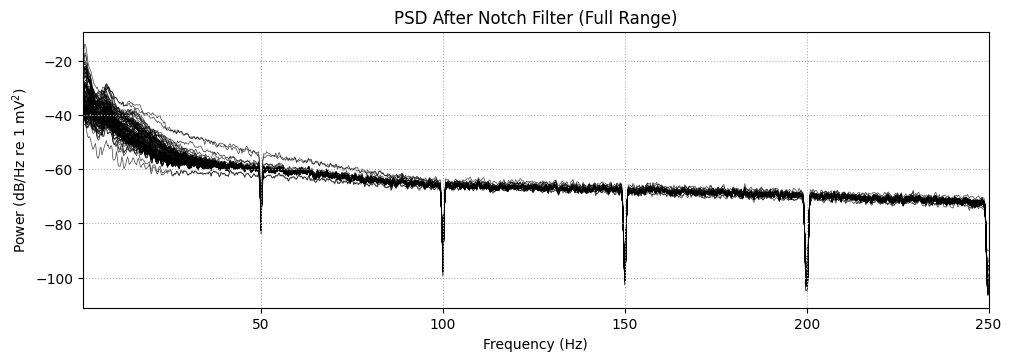

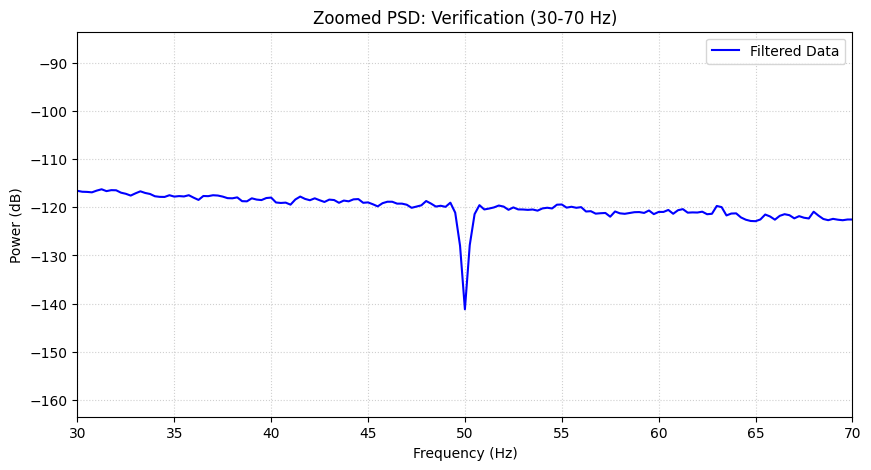

In [19]:
import matplotlib.pyplot as plt
import numpy as np

print("Computing PSD of filtered data...")

# 1. Compute PSD
spectrum = raw.compute_psd(method='welch', fmin=1, fmax=250, n_fft=2048, n_overlap=1024)

# 2. Plot 1: Full Range
spectrum.plot(show=False)
plt.title("PSD After Notch Filter (Full Range)")
plt.show()

# 3. Plot 2: Zoomed (30-70 Hz) to verify the cut
psds, freqs = spectrum.get_data(return_freqs=True)
avg_psd_db = 10 * np.log10(psds.mean(axis=0))

plt.figure(figsize=(10, 5))
plt.plot(freqs, avg_psd_db, color='blue', linewidth=1.5, label='Filtered Data')
plt.xlim(30, 70)  # Focus on the notch area
plt.title("Zoomed PSD: Verification (30-70 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.legend()
plt.show()

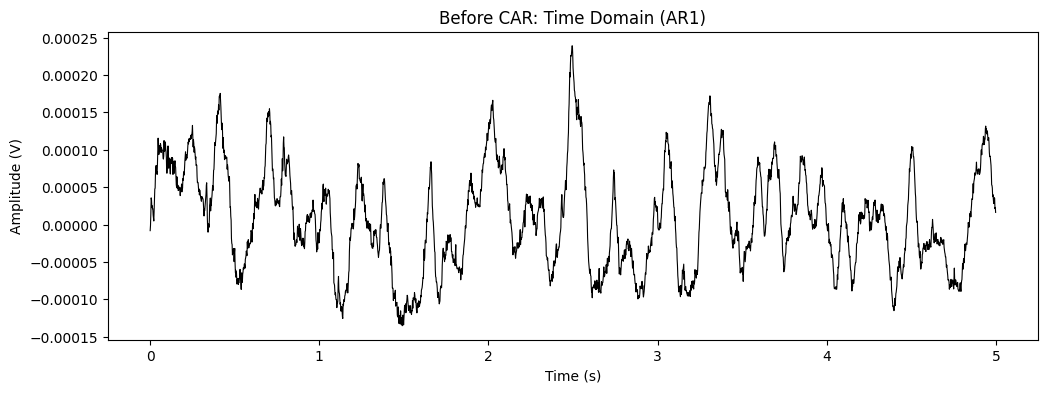

Computing PSD (Before CAR)...
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


C:\Users\USER\AppData\Local\Temp\ipykernel_28052\3943870968.py:24: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(show=False)


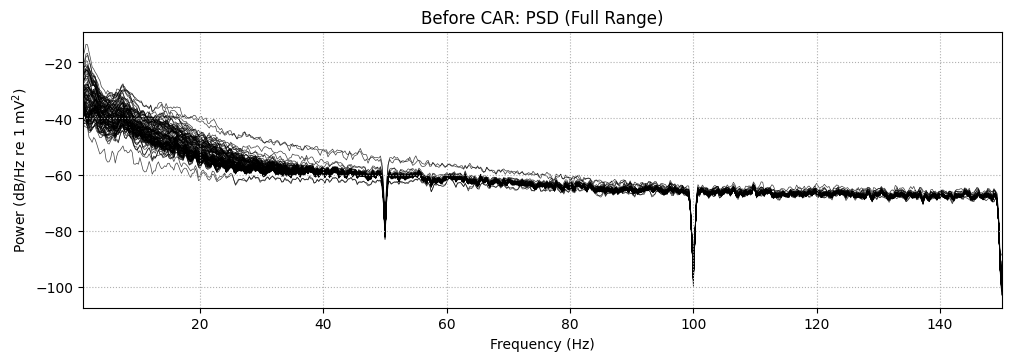

In [20]:
import matplotlib.pyplot as plt
import mne
import numpy as np

# --- 1. Plot Time Domain (Before) ---
# Pick the first good channel to see what the raw signal looks like
picks = mne.pick_types(raw.info, ecog=True, seeg=True, eeg=True, exclude='bads')
chan_name = raw.ch_names[picks[0]]
start, stop = 0, 5  # Plot first 5 seconds

data, times = raw[picks[0], :int(raw.info['sfreq'] * stop)]

plt.figure(figsize=(12, 4))
plt.plot(times, data.T, color='black', linewidth=0.8)
plt.title(f"Before CAR: Time Domain ({chan_name})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.show()

# --- 2. Plot PSD (Before) ---
# This is your code, just adapted to run on 'raw'
print("Computing PSD (Before CAR)...")
spectrum = raw.compute_psd(method='welch', fmin=1, fmax=150, n_fft=2048)
spectrum.plot(show=False)
plt.title("Before CAR: PSD (Full Range)")
plt.show()

sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.


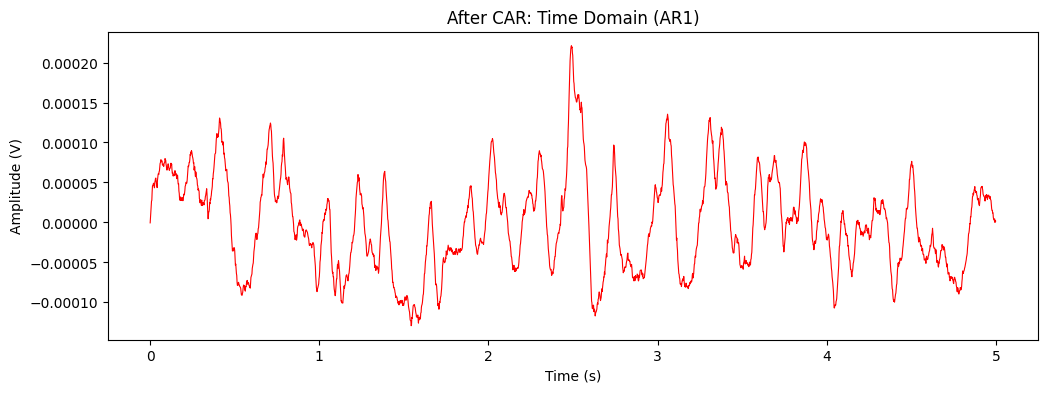

Computing PSD (After CAR)...
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


C:\Users\USER\AppData\Local\Temp\ipykernel_28052\3513355710.py:19: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum_car.plot(show=False)


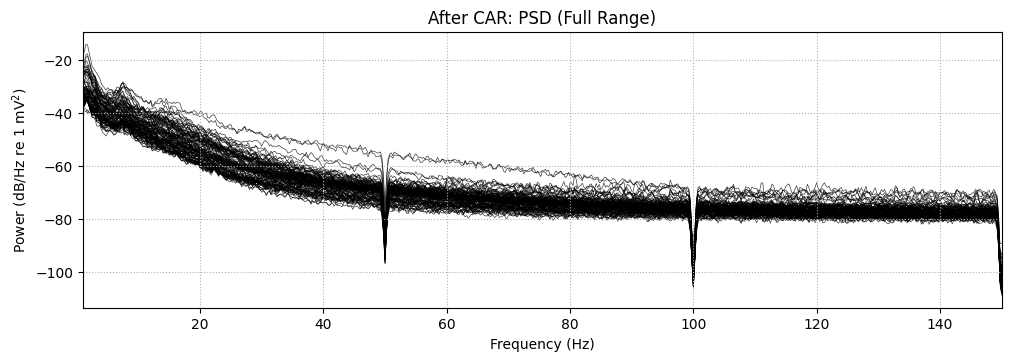

In [21]:
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')   #basically just creating a copy of the raw data, computing the average and then using this as a 'baseline' noise and subtracting it from all noise data
#For eg, the patient moved their jaw, or there's some external disturbance that appears on all electrodes at once, you can nullify it by using this maneuveur

# --- 1. Plot Time Domain (After) ---
# Using the same channel as before to compare
data_clean, times = raw_car[picks[0], :int(raw_car.info['sfreq'] * stop)]

plt.figure(figsize=(12, 4))
plt.plot(times, data_clean.T, color='red', linewidth=0.8)
plt.title(f"After CAR: Time Domain ({chan_name})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.show()

# --- 2. Plot PSD (After) ---
print("Computing PSD (After CAR)...")
# Note: We are now plotting 'raw_car'
spectrum_car = raw_car.compute_psd(method='welch', fmin=1, fmax=150, n_fft=2048)
spectrum_car.plot(show=False)
plt.title("After CAR: PSD (Full Range)")
plt.show()

In [22]:
#gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T  #applies a bandpass filter keeping only high frequency gamma bands as this is the best indicator of local brain activity in ieeg and filters out everything else
#the hilbert transform is to get the amplitude envelope because we do not care about the wiggle, rather about how big the wiggle is
#transpose to get Time x Channels because apparently this is used in many ML models too

In [23]:
"""
custom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,
                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,
                                                         use_rounding=False)

raw_car.plot(events=events, start=0, duration=180, color='gray', event_color={2: 'g', 1: 'r'}, bgcolor='w')
"""

"\ncustom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,\n                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan\nevents, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,\n                                                         use_rounding=False)\n\nraw_car.plot(events=events, start=0, duration=180, color='gray', event_color={2: 'g', 1: 'r'}, bgcolor='w')\n"

In [24]:
"""
import matplotlib.pyplot as plt
import mne
import numpy as np

# 1. Define the path to the file on disk (using the path you set up earlier)
# We need to reload it to get the "True Raw" data back
raw_path = data_path.match()[0] 

# 2. Load the True Raw data from disk (fresh copy)
true_raw = mne.io.read_raw_brainvision(str(raw_path), preload=True, verbose=False)

# 3. Resample it to match your current processing (512 Hz)
# If we don't do this, the time axes won't line up
true_raw.resample(512) 

# 4. Get your CURRENT 'raw' data (which is already filtered)
# We will call this 'clean_data'
clean_data = raw  

# 5. Extract data for the first 1 second
chan_to_plot = raw.ch_names[0]
start_idx = 0
end_idx = int(512 * 1.0) # 512 samples = 1 second

data_dirty = true_raw.get_data(picks=chan_to_plot, start=start_idx, stop=end_idx)[0]
data_clean = clean_data.get_data(picks=chan_to_plot, start=start_idx, stop=end_idx)[0]
times = true_raw.times[start_idx:end_idx]

# 6. Plot them
plt.figure(figsize=(12, 6))

# Plot Raw (Dirty) in Black
plt.plot(times, data_dirty, color='black', alpha=0.5, label='True Raw (From Disk)')

# Plot Filtered (Clean) in Red - make it dashed so you can see underneath
plt.plot(times, data_clean, color='red', linewidth=2, linestyle='--', label='Filtered (Current Data)')

plt.title(f"Edge Ringing Artifact: Channel {chan_to_plot}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.legend()
plt.xlim(0, 0.5) 
plt.show()
"""

'\nimport matplotlib.pyplot as plt\nimport mne\nimport numpy as np\n\n# 1. Define the path to the file on disk (using the path you set up earlier)\n# We need to reload it to get the "True Raw" data back\nraw_path = data_path.match()[0] \n\n# 2. Load the True Raw data from disk (fresh copy)\ntrue_raw = mne.io.read_raw_brainvision(str(raw_path), preload=True, verbose=False)\n\n# 3. Resample it to match your current processing (512 Hz)\n# If we don\'t do this, the time axes won\'t line up\ntrue_raw.resample(512) \n\n# 4. Get your CURRENT \'raw\' data (which is already filtered)\n# We will call this \'clean_data\'\nclean_data = raw  \n\n# 5. Extract data for the first 1 second\nchan_to_plot = raw.ch_names[0]\nstart_idx = 0\nend_idx = int(512 * 1.0) # 512 samples = 1 second\n\ndata_dirty = true_raw.get_data(picks=chan_to_plot, start=start_idx, stop=end_idx)[0]\ndata_clean = clean_data.get_data(picks=chan_to_plot, start=start_idx, stop=end_idx)[0]\ntimes = true_raw.times[start_idx:end_idx]\n